<a href="https://colab.research.google.com/github/Venura-Shiromal/NASA-Space-Apps-2025/blob/main/TOI_ClassificationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prerequisities

In [131]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Loading Data

In [132]:
toi = pd.read_csv('sample_data/TOI_2025.09.26_07.08.49.csv', comment='#')
toi.head()

,toi,tid,tfopwg_disp,rastr,ra,decstr,dec,st_pmra,st_pmraerr1,st_pmraerr2,...,st_logg,st_loggerr1,st_loggerr2,st_logglim,st_rad,st_raderr1,st_raderr2,st_radlim,toi_created,rowupdate
0,1000.01,50365310,FP,07h29m25.85s,112.357708,-12d41m45.46s,-12.695960,-5.964,0.085,-0.085,...,4.19,0.07,-0.07,0,2.16986,0.072573,-0.072573,0,2019-07-24 15:58:33,2024-09-09 10:08:01
1,1001.01,88863718,PC,08h10m19.31s,122.580465,-05d30m49.87s,-5.513852,-4.956,0.102,-0.102,...,4.03,0.09,-0.09,0,2.01000,0.090000,-0.090000,0,2019-07-24 15:58:33,2023-04-03 14:31:04
2,1002.01,124709665,FP,06h58m54.47s,104.726966,-10d34m49.64s,-10.580455,-1.462,0.206,-0.206,...,NaN,NaN,NaN,0,5.73000,NaN,NaN,0,2019-07-24 15:58:33,2022-07-11 16:02:02
3,1003.01,106997505,FP,07h22m14.39s,110.559945,-25d12m25.26s,-25.207017,-0.939,0.041,-0.041,...,4.15,1.64,-1.64,0,NaN,NaN,NaN,0,2019-07-24 15:58:33,2022-02-23 10:10:02
4,1004.01,238597883,FP,08h08m42.77s,122.178195,-48d48m10.12s,-48.802811,-4.496,0.069,-0.069,...,4.14,0.07,-0.07,0,2.15000,0.060000,-0.060000,0,2019-07-24 15:58:33,2024-09-09 10:08:01


## Feature Selection

In [133]:
features = ["pl_orbper", "pl_trandurh", "pl_trandep", "pl_rade", "pl_eqt", "pl_insol","st_teff", "st_logg", "st_rad", "st_tmag", "st_dist", "st_raderr1", "st_raderr2"]

Label Mapping

In [134]:
label_map = {
    "CP": 1,   # Confirmed Planet
    "KP": 1,   # Known Planet
    "PC": 0,   # Planetary Candidate
    "APC": 0,  # Ambiguous Planetary Candidate
    "FP": -1,  # False Positive
    "FA": -1   # False Alarm
}

toi["tfopwg_disp"] = toi["tfopwg_disp"].map(label_map)

## Filling empty cells

### Numerical Values

In [135]:
numerical_cols = ["pl_orbper","pl_trandurh","pl_trandep","pl_rade",
                  "pl_insol","pl_eqt","st_teff","st_logg","st_rad",
                  "st_tmag","st_dist", "st_raderr1", "st_raderr2"]

for col in numerical_cols:
    toi[col].fillna(toi[col].mean(), inplace=True)


/tmp/ipython-input-2967634529.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  toi[col].fillna(toi[col].mean(), inplace=True)


### Strings

In [136]:
toi["tfopwg_disp"].fillna(toi["tfopwg_disp"].mode(), inplace=True)

/tmp/ipython-input-2156541520.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  toi["tfopwg_disp"].fillna(toi["tfopwg_disp"].mode(), inplace=True)


Checking if NaN available

In [137]:
print(toi.isna().sum())

toi            0
tid            0
tfopwg_disp    0
rastr          0
ra             0
              ..
st_raderr1     0
st_raderr2     0
st_radlim      0
toi_created    0
rowupdate      0
Length: 65, dtype: int64


Defining data sets

In [138]:
X = toi[features]
y = toi["tfopwg_disp"]

In [139]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
    )

Defining Classes

In [140]:
classes = np.unique(y_train)

Calculating Class Weights

In [141]:
weights = compute_class_weight("balanced", classes=classes, y=y_train)

Combining both

In [142]:
class_weights = dict(zip(classes, weights))

## Cat Boost Initiation

### Parameters


In [143]:
max_ite = 2000
dep = 6
l_rate = 0.02

In [144]:
model = CatBoostClassifier(
    iterations=max_ite,
    depth=dep,
    learning_rate=l_rate,
    loss_function="MultiClass",
    eval_metric="MultiClass",
    l2_leaf_reg=5,
    early_stopping_rounds=50,
    random_seed=42,
    verbose=50,
    class_weights=class_weights
)


# Training

In [145]:
model.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	learn: 1.0915909	test: 1.0919533	best: 1.0919533 (0)	total: 12.3ms	remaining: 24.5s
50:	learn: 0.9210652	test: 0.9296690	best: 0.9296690 (50)	total: 634ms	remaining: 24.2s
100:	learn: 0.8546234	test: 0.8706804	best: 0.8706804 (100)	total: 1.24s	remaining: 23.2s
150:	learn: 0.8142583	test: 0.8376305	best: 0.8376305 (150)	total: 1.87s	remaining: 22.9s
200:	learn: 0.7863736	test: 0.8163837	best: 0.8163837 (200)	total: 2.46s	remaining: 22s
250:	learn: 0.7643570	test: 0.8013635	best: 0.8013635 (250)	total: 3.09s	remaining: 21.5s
300:	learn: 0.7454136	test: 0.7885186	best: 0.7885186 (300)	total: 3.71s	remaining: 20.9s
350:	learn: 0.7290478	test: 0.7782085	best: 0.7782085 (350)	total: 4.3s	remaining: 20.2s
400:	learn: 0.7147468	test: 0.7700978	best: 0.7700978 (400)	total: 4.91s	remaining: 19.6s
450:	learn: 0.7010765	test: 0.7635303	best: 0.7635303 (450)	total: 5.51s	remaining: 18.9s
500:	learn: 0.6885147	test: 0.7576786	best: 0.7576786 (500)	total: 6.12s	remaining: 18.3s
550:	learn: 0.6770

### Plotting Loss

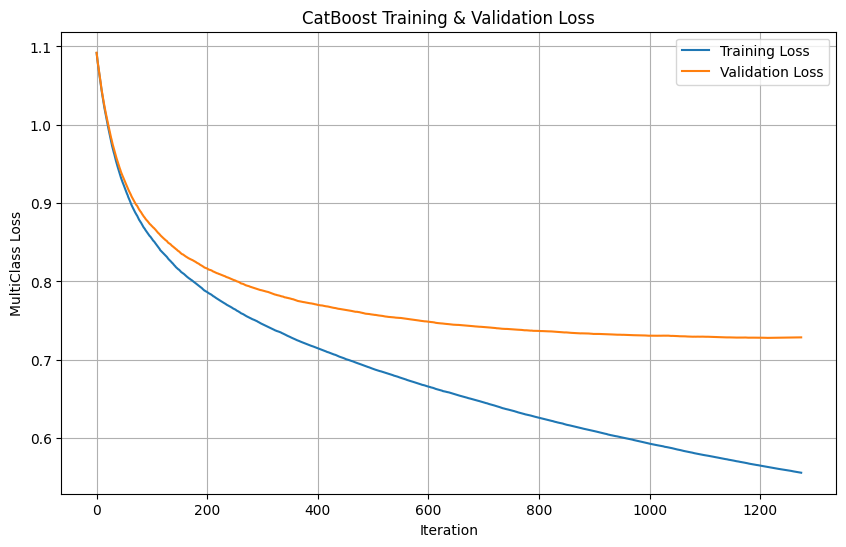

In [149]:
evals_result = model.get_evals_result()

train_loss = evals_result['learn']['MultiClass']
valid_loss = evals_result['validation']['MultiClass']

# Plot
plt.figure(figsize=(10,6))
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('MultiClass Loss')
plt.title('CatBoost Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation

In [146]:
y_pred = model.predict(X_test)

### Confusion Matrix

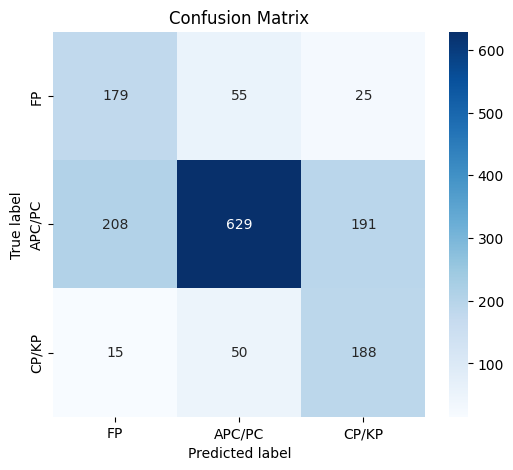

In [147]:
cm = confusion_matrix(y_test, y_pred)

class_names = ["FP", "APC/PC", "CP/KP"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

Accuracy

In [148]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(acc * 100))

Accuracy: 64.68%
